In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from scipy.sparse import save_npz, load_npz

import keras.backend as K
from keras.models import Model
from keras.layers import Input, Dropout, Dense
from keras.regularizers import l2
from keras.optimizers import SGD

Using TensorFlow backend.


In [2]:
# config
batch_size = 128
epochs = 25
reg = 0.0001
#reg = 0

A = load_npz("Atrain_re.npz")
A_test = load_npz("Atest_re.npz")
mask = (A > 0) * 1.0
mask_test = (A_test > 0) * 1.0

# make copies since we will shuffle
A_copy = A.copy()
mask_copy = mask.copy()
A_test_copy = A_test.copy()
mask_test_copy = mask_test.copy()

N, M = A.shape
print("N:", N, "M:", M)
print("N // batch_size:", N // batch_size)

# center the data
mu = A.sum() / mask.sum()
print("mu:", mu)

# build the model - just a 1 hidden layer autoencoder
i = Input(shape=(M,))
# bigger hidden layer size seems to help!
x = Dropout(0.7)(i)
x = Dense(700, activation='tanh', kernel_regularizer=l2(reg))(x)
# x = Dropout(0.5)(x)
x = Dense(M, kernel_regularizer=l2(reg))(x)

N: 480189 M: 17770
N // batch_size: 3751
mu: 3.60434573099098


In [3]:
def custom_loss(y_true, y_pred):
    mask = K.cast(K.not_equal(y_true, 0), dtype='float32')
    diff = y_pred - y_true
    sqdiff = diff * diff * mask
    sse = K.sum(K.sum(sqdiff))
    n = K.sum(K.sum(mask))
    return sse / n


def generator(A, M):
    while True:
        A, M = shuffle(A, M)
        for i in range(A.shape[0] // batch_size + 1):
            upper = min((i+1)*batch_size, A.shape[0])
            a = A[i*batch_size:upper].toarray()
            m = M[i*batch_size:upper].toarray()
            a = a - mu * m # must keep zeros at zero!
            # m2 = (np.random.random(a.shape) > 0.5)
            # noisy = a * m2
            noisy = a # no noise
            yield noisy, a


def test_generator(A, M, A_test, M_test):
    # assumes A and A_test are in corresponding order
    # both of size N x M
    while True:
        for i in range(A.shape[0] // batch_size + 1):
            upper = min((i+1)*batch_size, A.shape[0])
            a = A[i*batch_size:upper].toarray()
            m = M[i*batch_size:upper].toarray()
            at = A_test[i*batch_size:upper].toarray()
            mt = M_test[i*batch_size:upper].toarray()
            a = a - mu * m
            at = at - mu * mt
            yield a, at

In [4]:
model = Model(i, x)
model.compile(
  loss=custom_loss,
  optimizer=SGD(lr=0.08, momentum=0.9),
  # optimizer='adam',
  metrics=[custom_loss],
)


r = model.fit_generator(
  generator(A, mask),
  validation_data=test_generator(A_copy, mask_copy, A_test_copy, mask_test_copy),
  epochs=epochs,
  steps_per_epoch=A.shape[0] // batch_size + 1,
  validation_steps=A_test.shape[0] // batch_size + 1,
)
print(r.history.keys())

Epoch 1/25
3752/3752 [==============================] - 522s 139ms/step - loss: 0.9314 - custom_loss: 0.7511 - val_loss: 0.8544 - val_custom_loss: 0.7581
Epoch 2/25
3752/3752 [==============================] - 520s 138ms/step - loss: 0.7801 - custom_loss: 0.6851 - val_loss: 0.8030 - val_custom_loss: 0.7459
Epoch 3/25
3752/3752 [==============================] - 520s 139ms/step - loss: 0.7448 - custom_loss: 0.6737 - val_loss: 0.7852 - val_custom_loss: 0.7409
Epoch 4/25
3752/3752 [==============================] - 520s 139ms/step - loss: 0.7334 - custom_loss: 0.6685 - val_loss: 0.7833 - val_custom_loss: 0.7382
Epoch 5/25
3752/3752 [==============================] - 521s 139ms/step - loss: 0.7288 - custom_loss: 0.6649 - val_loss: 0.7813 - val_custom_loss: 0.7371
Epoch 6/25
3752/3752 [==============================] - 521s 139ms/step - loss: 0.7272 - custom_loss: 0.6629 - val_loss: 0.7798 - val_custom_loss: 0.7363
Epoch 7/25
3752/3752 [==============================] - 522s 139ms/step - lo

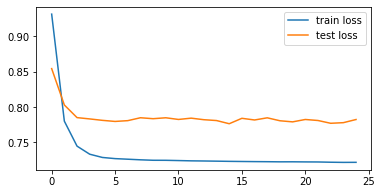

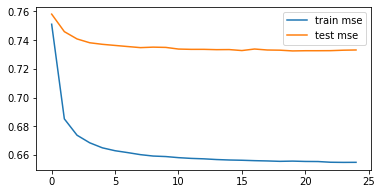

In [5]:
# plot losses
plt.figure(figsize = (6, 3))
plt.plot(r.history['loss'], label="train loss")
plt.plot(r.history['val_loss'], label="test loss")
plt.legend()
plt.show()

# plot mse
plt.figure(figsize = (6, 3))
plt.plot(r.history['custom_loss'], label="train mse")
plt.plot(r.history['val_custom_loss'], label="test mse")
plt.legend()
plt.show()

In [6]:
print('The resulting val_loss is about: {}'.format(r.history['val_custom_loss'][-1]))

The resulting val_loss is about: 0.7331628203392029


In [7]:
0.7331628203392029**(1/2)

0.8562492746503222